<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Baseline Models with Opponent Impact Features</h4>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Baseline-Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Training Windows](#Inspect-Training-Windows)

- [Expanding](#Expanding)

- [Rolling](#Rolling)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**

- [1.1. Expanding Window](#1.1.-Expanding-Window)

- [1.2. Rolling Window](#1.2.-Rolling-Window)

**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

- [2.1. Expanding Window](#2.1.-Expanding-Window)

- [2.2. Rolling Window](#2.2.-Rolling-Window)

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

- [3.1. Expanding Window](#3.1.-Expanding-Window)

- [3.2. Rolling Window](#3.2.-Rolling-Window)

# Setup

[Return to top](#Baseline-Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Baseline-Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_rolling_opponent_impact_box_scores_2022_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLLDIFF_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 692 games
Total number of games across sampled seasons: 3059 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181

In [4]:
pts_scaled_df.head()

,ROLLDIFF_HOME_PTS,ROLLDIFF_HOME_FGM,ROLLDIFF_HOME_FGA,ROLLDIFF_HOME_FG_PCT,ROLLDIFF_HOME_FG3M,ROLLDIFF_HOME_FG3A,ROLLDIFF_HOME_FG3_PCT,ROLLDIFF_HOME_FTM,ROLLDIFF_HOME_FTA,ROLLDIFF_HOME_FT_PCT,ROLLDIFF_HOME_OREB,ROLLDIFF_HOME_DREB,ROLLDIFF_HOME_REB,ROLLDIFF_HOME_AST,ROLLDIFF_HOME_STL,ROLLDIFF_HOME_BLK,ROLLDIFF_HOME_TOV,ROLLDIFF_HOME_PF,ROLLDIFF_AWAY_PTS,ROLLDIFF_AWAY_FGM,ROLLDIFF_AWAY_FGA,ROLLDIFF_AWAY_FG_PCT,ROLLDIFF_AWAY_FG3M,ROLLDIFF_AWAY_FG3A,ROLLDIFF_AWAY_FG3_PCT,ROLLDIFF_AWAY_FTM,ROLLDIFF_AWAY_FTA,ROLLDIFF_AWAY_FT_PCT,ROLLDIFF_AWAY_OREB,ROLLDIFF_AWAY_DREB,ROLLDIFF_AWAY_REB,ROLLDIFF_AWAY_AST,ROLLDIFF_AWAY_STL,ROLLDIFF_AWAY_BLK,ROLLDIFF_AWAY_TOV,ROLLDIFF_AWAY_PF,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.641,0.485,0.387,0.488,0.686,0.630,0.606,0.692,0.583,0.650,0.413,0.585,0.485,0.519,0.575,0.552,0.500,0.571,0.482,0.509,0.667,0.428,0.461,0.406,0.644,0.450,0.385,0.519,0.542,0.525,0.437,0.381,0.533,0.481,0.280,0.654,185
2021-10-23,0.286,0.288,0.655,0.130,0.605,0.721,0.475,0.413,0.417,0.372,0.653,0.455,0.500,0.331,0.219,0.621,0.639,0.464,0.472,0.491,0.551,0.464,0.500,0.654,0.441,0.433,0.438,0.390,0.561,0.417,0.364,0.467,0.300,0.370,0.402,0.641,198
2021-10-23,0.484,0.523,0.328,0.569,0.256,0.260,0.351,0.577,0.433,0.818,0.347,0.675,0.530,0.459,0.301,0.534,0.556,0.440,0.365,0.473,0.622,0.399,0.211,0.338,0.260,0.400,0.308,0.523,0.486,0.442,0.331,0.171,0.600,0.537,0.366,0.821,239
2021-10-23,0.508,0.538,0.756,0.346,0.593,0.604,0.530,0.317,0.394,0.224,0.533,0.317,0.303,0.504,0.603,0.069,0.278,0.536,0.149,0.161,0.494,0.188,0.171,0.496,0.095,0.500,0.400,0.627,0.523,0.300,0.245,0.314,0.350,0.407,0.585,0.551,232
2021-10-24,0.738,0.750,0.571,0.715,0.698,0.558,0.713,0.240,0.213,0.520,0.453,0.634,0.553,0.624,0.315,0.707,0.528,0.548,0.309,0.268,0.635,0.232,0.434,0.632,0.359,0.508,0.523,0.415,0.579,0.342,0.318,0.571,0.400,0.611,0.463,0.538,204


In [5]:
pm_scaled_df.head()

,ROLLDIFF_HOME_PTS,ROLLDIFF_HOME_FGM,ROLLDIFF_HOME_FGA,ROLLDIFF_HOME_FG_PCT,ROLLDIFF_HOME_FG3M,ROLLDIFF_HOME_FG3A,ROLLDIFF_HOME_FG3_PCT,ROLLDIFF_HOME_FTM,ROLLDIFF_HOME_FTA,ROLLDIFF_HOME_FT_PCT,ROLLDIFF_HOME_OREB,ROLLDIFF_HOME_DREB,ROLLDIFF_HOME_REB,ROLLDIFF_HOME_AST,ROLLDIFF_HOME_STL,ROLLDIFF_HOME_BLK,ROLLDIFF_HOME_TOV,ROLLDIFF_HOME_PF,ROLLDIFF_AWAY_PTS,ROLLDIFF_AWAY_FGM,ROLLDIFF_AWAY_FGA,ROLLDIFF_AWAY_FG_PCT,ROLLDIFF_AWAY_FG3M,ROLLDIFF_AWAY_FG3A,ROLLDIFF_AWAY_FG3_PCT,ROLLDIFF_AWAY_FTM,ROLLDIFF_AWAY_FTA,ROLLDIFF_AWAY_FT_PCT,ROLLDIFF_AWAY_OREB,ROLLDIFF_AWAY_DREB,ROLLDIFF_AWAY_REB,ROLLDIFF_AWAY_AST,ROLLDIFF_AWAY_STL,ROLLDIFF_AWAY_BLK,ROLLDIFF_AWAY_TOV,ROLLDIFF_AWAY_PF,PLUS_MINUS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.641,0.485,0.387,0.488,0.686,0.630,0.606,0.692,0.583,0.650,0.413,0.585,0.485,0.519,0.575,0.552,0.500,0.571,0.482,0.509,0.667,0.428,0.461,0.406,0.644,0.450,0.385,0.519,0.542,0.525,0.437,0.381,0.533,0.481,0.280,0.654,7.0
2021-10-23,0.286,0.288,0.655,0.130,0.605,0.721,0.475,0.413,0.417,0.372,0.653,0.455,0.500,0.331,0.219,0.621,0.639,0.464,0.472,0.491,0.551,0.464,0.500,0.654,0.441,0.433,0.438,0.390,0.561,0.417,0.364,0.467,0.300,0.370,0.402,0.641,-8.0
2021-10-23,0.484,0.523,0.328,0.569,0.256,0.260,0.351,0.577,0.433,0.818,0.347,0.675,0.530,0.459,0.301,0.534,0.556,0.440,0.365,0.473,0.622,0.399,0.211,0.338,0.260,0.400,0.308,0.523,0.486,0.442,0.331,0.171,0.600,0.537,0.366,0.821,29.0
2021-10-23,0.508,0.538,0.756,0.346,0.593,0.604,0.530,0.317,0.394,0.224,0.533,0.317,0.303,0.504,0.603,0.069,0.278,0.536,0.149,0.161,0.494,0.188,0.171,0.496,0.095,0.500,0.400,0.627,0.523,0.300,0.245,0.314,0.350,0.407,0.585,0.551,-10.0
2021-10-24,0.738,0.750,0.571,0.715,0.698,0.558,0.713,0.240,0.213,0.520,0.453,0.634,0.553,0.624,0.315,0.707,0.528,0.548,0.309,0.268,0.635,0.232,0.434,0.632,0.359,0.508,0.523,0.415,0.579,0.342,0.318,0.571,0.400,0.611,0.463,0.538,-10.0


In [6]:
res_scaled_df.head()

,ROLLDIFF_HOME_PTS,ROLLDIFF_HOME_FGM,ROLLDIFF_HOME_FGA,ROLLDIFF_HOME_FG_PCT,ROLLDIFF_HOME_FG3M,ROLLDIFF_HOME_FG3A,ROLLDIFF_HOME_FG3_PCT,ROLLDIFF_HOME_FTM,ROLLDIFF_HOME_FTA,ROLLDIFF_HOME_FT_PCT,ROLLDIFF_HOME_OREB,ROLLDIFF_HOME_DREB,ROLLDIFF_HOME_REB,ROLLDIFF_HOME_AST,ROLLDIFF_HOME_STL,ROLLDIFF_HOME_BLK,ROLLDIFF_HOME_TOV,ROLLDIFF_HOME_PF,ROLLDIFF_AWAY_PTS,ROLLDIFF_AWAY_FGM,ROLLDIFF_AWAY_FGA,ROLLDIFF_AWAY_FG_PCT,ROLLDIFF_AWAY_FG3M,ROLLDIFF_AWAY_FG3A,ROLLDIFF_AWAY_FG3_PCT,ROLLDIFF_AWAY_FTM,ROLLDIFF_AWAY_FTA,ROLLDIFF_AWAY_FT_PCT,ROLLDIFF_AWAY_OREB,ROLLDIFF_AWAY_DREB,ROLLDIFF_AWAY_REB,ROLLDIFF_AWAY_AST,ROLLDIFF_AWAY_STL,ROLLDIFF_AWAY_BLK,ROLLDIFF_AWAY_TOV,ROLLDIFF_AWAY_PF,GAME_RESULT
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.641,0.485,0.387,0.488,0.686,0.630,0.606,0.692,0.583,0.650,0.413,0.585,0.485,0.519,0.575,0.552,0.500,0.571,0.482,0.509,0.667,0.428,0.461,0.406,0.644,0.450,0.385,0.519,0.542,0.525,0.437,0.381,0.533,0.481,0.280,0.654,1
2021-10-23,0.286,0.288,0.655,0.130,0.605,0.721,0.475,0.413,0.417,0.372,0.653,0.455,0.500,0.331,0.219,0.621,0.639,0.464,0.472,0.491,0.551,0.464,0.500,0.654,0.441,0.433,0.438,0.390,0.561,0.417,0.364,0.467,0.300,0.370,0.402,0.641,0
2021-10-23,0.484,0.523,0.328,0.569,0.256,0.260,0.351,0.577,0.433,0.818,0.347,0.675,0.530,0.459,0.301,0.534,0.556,0.440,0.365,0.473,0.622,0.399,0.211,0.338,0.260,0.400,0.308,0.523,0.486,0.442,0.331,0.171,0.600,0.537,0.366,0.821,1
2021-10-23,0.508,0.538,0.756,0.346,0.593,0.604,0.530,0.317,0.394,0.224,0.533,0.317,0.303,0.504,0.603,0.069,0.278,0.536,0.149,0.161,0.494,0.188,0.171,0.496,0.095,0.500,0.400,0.627,0.523,0.300,0.245,0.314,0.350,0.407,0.585,0.551,0
2021-10-24,0.738,0.750,0.571,0.715,0.698,0.558,0.713,0.240,0.213,0.520,0.453,0.634,0.553,0.624,0.315,0.707,0.528,0.548,0.309,0.268,0.635,0.232,0.434,0.632,0.359,0.508,0.523,0.415,0.579,0.342,0.318,0.571,0.400,0.611,0.463,0.538,0


# Inspect Training Windows

[Return to top](#Baseline-Models)

## Expanding

[Return to top](#Baseline-Models)

In [7]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
gap_size=0               # should there be a gap between train and test sets?
expansion_limit=None     # the limit on the test set observations

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_scaled_df, initial_train_size, 
                                                                 test_size=test_size, gap_size=gap_size,
                                                                 expansion_limit=expansion_limit):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

## Rolling

[Return to top](#Baseline-Models)

In [8]:
# expanding window configuration
train_size = 10 # size of training set window
test_size = 1   # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

for train_index, test_index in utl.rolling_window_ts_split(pts_scaled_df, train_size, test_size):
    print("TRAIN:", train_index, "TEST:", test_index)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [14 15 16 17 18 19 20 21 22 23] TEST: [24]


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Baseline-Models)

<a name="1.1.-Expanding-Window"></a>
## 1.1. Expanding Window

[Return to top](#Baseline-Models)

In [9]:
# configuration for total points with expanding window
model = LinearRegression()  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
lr, model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    fitted_model=True
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 2.08 seconds


In [10]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 20.79
- Null RMSE: 20.27


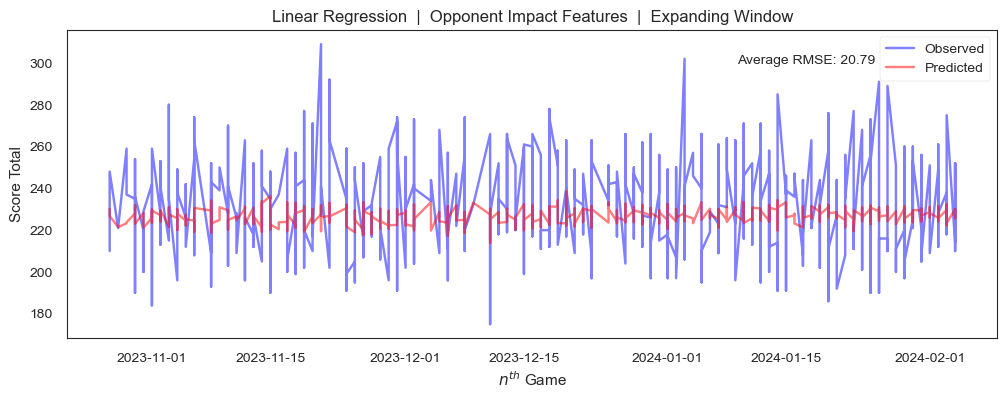

In [11]:
utl.plot_model_performance(
    title='Linear Regression  |  Opponent Impact Features  |  Expanding Window',
    y_label='Score Total',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="1.2.-Rolling-Window"></a>
## 1.2. Rolling Window

[Return to top](#Baseline-Models)

In [12]:
# configuration for total points with rolling window
model = LinearRegression()  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_scaled_df          # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit
)

Total time taken: 4.15 seconds


In [13]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 20.10
- Null RMSE: 19.87


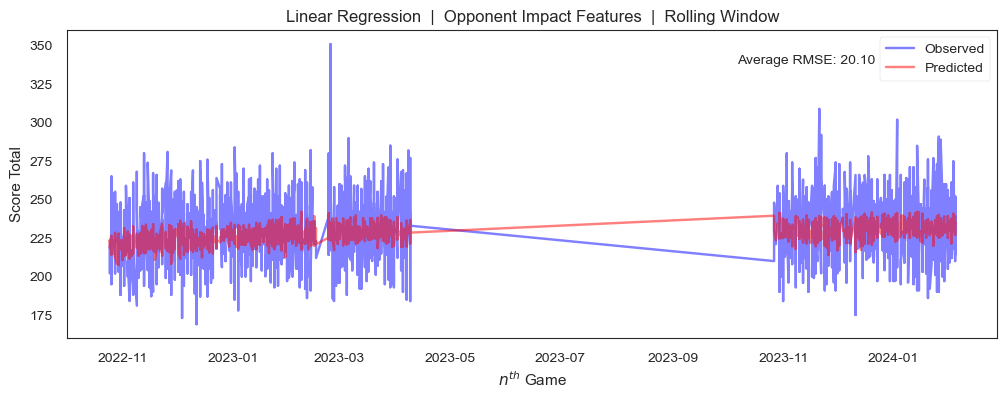

In [14]:
utl.plot_model_performance_rolling(
    title='Linear Regression  |  Opponent Impact Features  |  Rolling Window',
    y_label='Score Total',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    train_size=train_size
)

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Baseline-Models)

<a name="2.1.-Expanding-Window"></a>
## 2.1. Expanding Window

[Return to top](#Baseline-Models)

In [15]:
# configuration for point difference with expanding window
model = LinearRegression()  # model class
target_col = 'PLUS_MINUS'   # target column name
df = pm_scaled_df           # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 2.22 seconds


In [16]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 14.35
- Null RMSE: 15.31


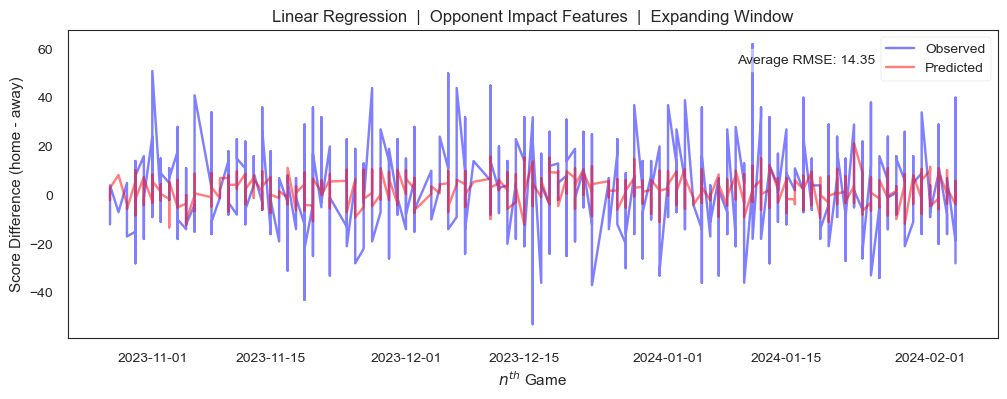

In [17]:
utl.plot_model_performance(
    title='Linear Regression  |  Opponent Impact Features  |  Expanding Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="2.2.-Rolling-Window"></a>
## 2.2. Rolling Window

[Return to top](#Baseline-Models)

In [18]:
# configuration for points difference with rolling window
model = LinearRegression()  # model class
target_col = 'PLUS_MINUS'   # target column name
df = pm_scaled_df           # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit
)

Total time taken: 4.57 seconds


In [19]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 13.91
- Null RMSE: 14.28


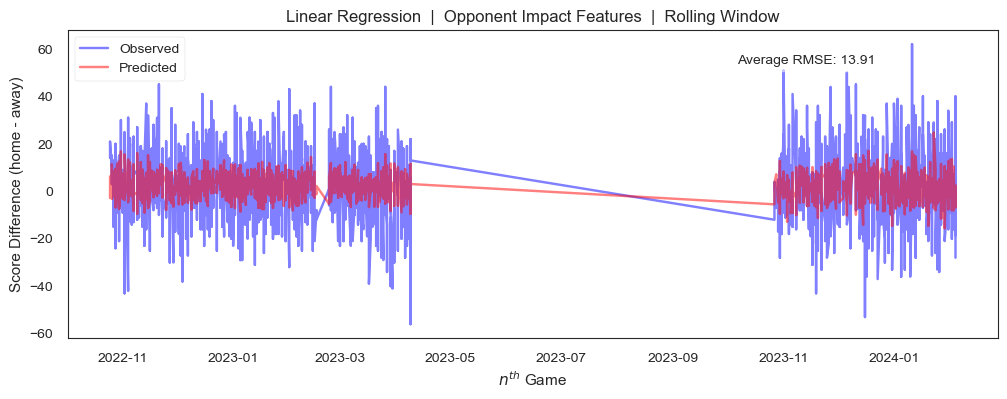

In [20]:
utl.plot_model_performance_rolling(
    title='Linear Regression  |  Opponent Impact Features  |  Rolling Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    train_size=train_size
)

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Baseline-Models)

<a name="3.1.-Expanding-Window"></a>
## 3.1. Expanding Window

[Return to top](#Baseline-Models)

In [21]:
# configuration for game winner with expanding window
model = LogisticRegression(penalty=None, max_iter=10000, solver='lbfgs')  # model class
target_col = 'GAME_RESULT'  # target column name
df = res_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    ensure_diversity=True # ensure class diversity in training
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 39.89 seconds


In [22]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Baseline Accuracy: 0.56
- Average Accuracy: 0.63
- Overall AUC: 0.67
- Average F1 Score: 0.69


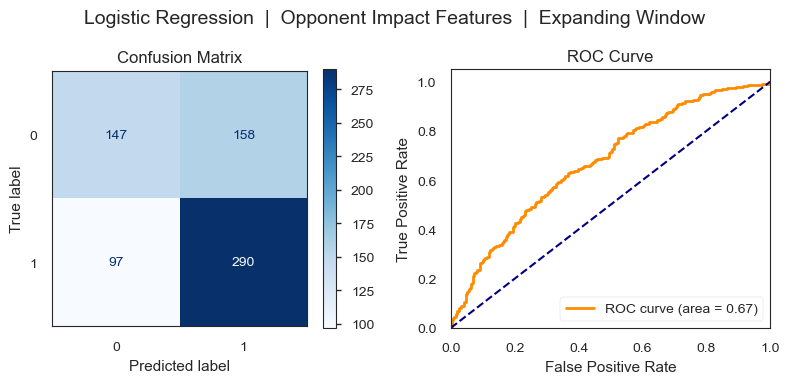

In [23]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Logistic Regression  |  Opponent Impact Features  |  Expanding Window'
)

In [24]:
# write out all model predictions and meta-data
test_set_obs.rename(columns={
    'TOTAL_PTS': 'TOTAL_PTS_PREDS',
    'PLUS_MINUS': 'PLUS_MINUS_PREDS',
    'GAME_RESULT': 'GAME_RESULT_PREDS'
}, inplace=True)
columns_to_round = ['TOTAL_PTS_PREDS', 'PLUS_MINUS_PREDS', 'GAME_RESULT_PREDS']
test_set_obs[columns_to_round] = test_set_obs[columns_to_round].round(4)
test_set_obs.to_csv('../../data/model_predictions/GLM_preds_opponent_impact.csv', index=False)

<a name="3.2.-Rolling-Window"></a>
## 3.2. Rolling Window

[Return to top](#Baseline-Models)

In [25]:
# configuration for game winner with rolling window
model = LogisticRegression(penalty=None, max_iter=10000, solver='lbfgs')  # model class
target_col = 'GAME_RESULT'  # target column name
df = res_scaled_df          # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit,
    ensure_diversity=True # ensure class diversity in training
)

Total time taken: 81.21 seconds


In [26]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Baseline Accuracy: 0.57
- Average Accuracy: 0.59
- Overall AUC: 0.61
- Average F1 Score: 0.67


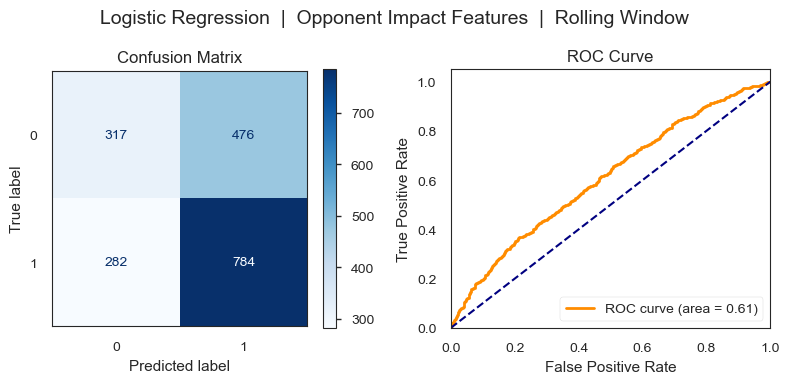

In [27]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Logistic Regression  |  Opponent Impact Features  |  Rolling Window'
)